# Example 5: Black Litterman Mean Risk Optimisation

The Black Litterman model only adjusts the vector of expected returns and covariance matrix. Therefore, it will only affect optimisations which make use of either of these.

## 1. Download data.

In [1]:
using PortfolioOptimiser, TimeSeries, DataFrames, PrettyTables, Clarabel, HiGHS, YFinance,
      GraphRecipes, StatsPlots, JuMP

# Format for pretty tables.
fmt1 = (v, i, j) -> begin
    if j == 1
        return Date(v)
    else
        return v
    end
end;
fmt2 = (v, i, j) -> begin
    if j == 1
        return v
    else
        return isa(v, Number) ? "$(round(v*100, digits=3)) %" : v
    end
end;

# Convert prices to time array.
function stock_price_to_time_array(x)
    # Only get the keys that are not ticker or datetime.
    coln = collect(keys(x))[3:end]
    # Convert the dictionary into a matrix.
    m = hcat([x[k] for k ∈ coln]...)
    return TimeArray(x["timestamp"], m, Symbol.(coln), x["ticker"])
end

# Asset tickers.
assets = sort!(["AAPL", "ADI", "ADP", "AMGN", "AMZN", "BKNG", "CMCSA", "COST", "CSCO",
                "GILD", "GOOG", "GOOGL", "HON", "ISRG", "LIN", "MAR", "META", "MRK", "MSFT",
                "NFLX", "NVDA", "ORLY", "PANW", "QCOM", "SBUX", "T", "TMUS", "TSLA", "TXN",
                "VRTX"])

# Prices date range.
Date_0 = "2019-01-01"
Date_1 = "2025-01-31"

# Download the price data using YFinance.
prices = get_prices.(assets; startdt = Date_0, enddt = Date_1)
prices = stock_price_to_time_array.(prices)
prices = hcat(prices...)
cidx = colnames(prices)[occursin.(r"adj", string.(colnames(prices)))]
prices = prices[cidx]
TimeSeries.rename!(prices, Symbol.(assets))
pretty_table(prices[1:5]; formatters = fmt1)

┌────────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│  timestamp │    AAPL │     ADI │     ADP │    AMGN │    AMZN │    BKNG │   CMCSA │    COST │    CSCO │    GILD │    GOOG │   GOOGL │     HON │    ISRG │     LIN │     MAR │    META │     MRK │    MSFT │    NFLX │    NVDA │    ORLY │    PANW │    QCOM │    SBUX │       T │    TMUS │    TSLA │     TXN │    VRTX │
│   DateTime │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├────────────┼─────────┼─────────┼─────────┼─────────┼─

## 2. Estimating Black Litterman Portfolios

### 2.1. Reference portfolio

This is a simple example so we will only use default parameters for computing the statistics.

For API details and options available see: `Portfolio`, `PortOptSolver`, `PortfolioOptimiser.MeanEstimator`, `PortfolioOptimiser.PortfolioOptimiserCovCor`, `BLType`, `asset_statistics!`, `black_litterman`, `RiskMeasure`, `PortfolioOptimiser.ObjectiveFunction`, `PortfolioOptimiser.OptimType`.

┌─────────┬──────────┐
│ tickers │  weights │
│  String │  Float64 │
├─────────┼──────────┤
│    AAPL │    0.0 % │
│     ADI │    0.0 % │
│     ADP │    0.0 % │
│    AMGN │    0.0 % │
│    AMZN │    0.0 % │
│    BKNG │    0.0 % │
│   CMCSA │    0.0 % │
│    COST │ 34.351 % │
│    CSCO │    0.0 % │
│    GILD │  5.666 % │
│    GOOG │    0.0 % │
│   GOOGL │    0.0 % │
│     HON │    0.0 % │
│    ISRG │    0.0 % │
│     LIN │    0.0 % │
│     MAR │    0.0 % │
│    META │    0.0 % │
│     MRK │    0.0 % │
│    MSFT │    0.0 % │
│    NFLX │    0.0 % │
│    NVDA │ 19.616 % │
│    ORLY │ 15.496 % │
│    PANW │  4.801 % │
│    QCOM │    0.0 % │
│    SBUX │    0.0 % │
│       T │    0.0 % │
│    TMUS │ 11.275 % │
│    TSLA │  8.794 % │
│     TXN │    0.0 % │
│    VRTX │    0.0 % │
└─────────┴──────────┘


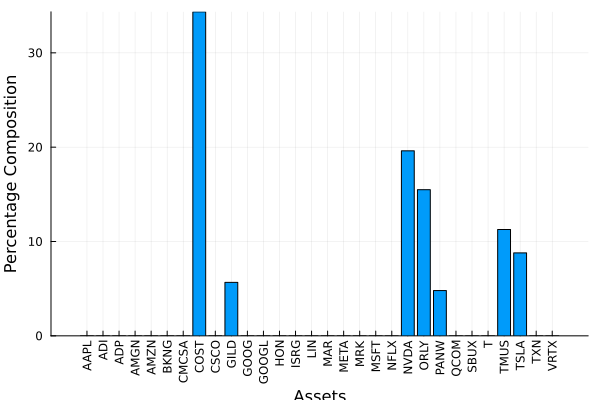

In [2]:
# Creating the portfolio object. Internally computes the returns if you give a prices TimeArray.
port = Portfolio(; prices = prices,
                 # Continuous solvers.
                 solvers = PortOptSolver(; name = :Clarabel, solver = Clarabel.Optimizer,
                                         params = Dict("verbose" => false)),
                 # Discrete solvers (for discrete allocation).
                 alloc_solvers = PortOptSolver(; name = :HiGHS,
                                               solver = optimizer_with_attributes(HiGHS.Optimizer,
                                                                                  MOI.Silent() => true)))

# Compute relevant statistics.
# Expected returns and covariance estimation methods.
mu_type = MuSimple()
cov_type = PortCovCor()

# Only compute `mu` and `cov`.
asset_statistics!(port; mu_type = mu_type, cov_type = cov_type, set_kurt = false,
                  set_skurt = false, set_skew = false, set_sskew = false)
# Creating the optimisation object.
rm = SD() # Risk measure.
obj = Sharpe() # Objective function. Can be `MinRisk()`, `Utility()`, `Sharpe()`, `MaxRet()`.
# `Trad` optimisation corresponds to the classic mean risk optimisation.
type = Trad(; rm = rm, obj = obj)

# Optimise portfolio.
w1 = optimise!(port, type)
pretty_table(w1; formatters = fmt2)
plot_bar(port)

### 2.2. Asset sets and asset views

The function `asset_views` takes in two dataframes, one defining the asset views, and another defining the asset sets.

In [3]:
asset_sets = DataFrame(;
                       Asset = ["AAPL", "ADI", "ADP", "AMGN", "AMZN", "BKNG", "CMCSA",
                                "COST", "CSCO", "GILD", "GOOG", "GOOGL", "HON", "ISRG",
                                "LIN", "MAR", "META", "MRK", "MSFT", "NFLX", "NVDA", "ORLY",
                                "PANW", "QCOM", "SBUX", "T", "TMUS", "TSLA", "TXN", "VRTX"],
                       Sector = ["Technology", "Technology", "Technology", "Health Care",
                                 "Consumer Discretionary", "Consumer Discretionary",
                                 "Telecommunications", "Consumer Discretionary",
                                 "Telecommunications", "Health Care", "Technology",
                                 "Technology", "Industrials", "Health Care", "Industrials",
                                 "Consumer Discretionary", "Technology", "Health Care",
                                 "Technology", "Consumer Discretionary", "Technology",
                                 "Consumer Discretionary", "Technology", "Technology",
                                 "Consumer Discretionary", "Telecommunications",
                                 "Telecommunications", "Consumer Discretionary",
                                 "Technology", "Health Care"],
                       Industry = ["Computer Manufacturing", "Semiconductors",
                                   "EDP Services",
                                   "Biotechnology: Biological Products (No Diagnostic Substances)",
                                   "Catalog/Specialty Distribution",
                                   "Transportation Services",
                                   "Cable & Other Pay Television Services",
                                   "Department/Specialty Retail Stores",
                                   "Computer Communications Equipment",
                                   "Biotechnology: Biological Products (No Diagnostic Substances)",
                                   "Computer Software: Programming Data Processing",
                                   "Computer Software: Programming Data Processing",
                                   "Aerospace", "Industrial Specialties", "Major Chemicals",
                                   "Hotels/Resorts",
                                   "Computer Software: Programming Data Processing",
                                   "Biotechnology: Pharmaceutical Preparations",
                                   "Computer Software: Prepackaged Software",
                                   "Consumer Electronics/Video Chains", "Semiconductors",
                                   "Auto & Home Supply Stores",
                                   "Computer peripheral equipment",
                                   "Radio And Television Broadcasting And Communications Equipment",
                                   "Restaurants", "Telecommunications Equipment",
                                   "Telecommunications Equipment", "Auto Manufacturing",
                                   "Semiconductors",
                                   "Biotechnology: Pharmaceutical Preparations"])
pretty_table(asset_sets)

views = DataFrame("Enabled" => [true, true, true, true, true, true, true, true, true, true,
                                true, true],
                  "Type" => ["Asset", "Asset", "Asset", "Asset", "Asset", "Asset", "Subset",
                             "Subset", "Subset", "Subset", "Subset", "Subset"],
                  "Set" => ["", "", "", "", "", "", "Sector", "Sector", "Industry",
                            "Industry", "Sector", "Industry"],
                  "Position" => ["AAPL", "AMZN", "COST", "T", "SBUX", "ADI", "Technology",
                                 "Consumer Discretionary", "Semiconductors",
                                 "Computer Software: Programming Data Processing",
                                 "Industrials",
                                 "Biotechnology: Biological Products (No Diagnostic Substances)"],
                  "Sign" => [">=", "<=", ">=", "<=", ">=", "<=", ">=", "<=", ">=", "<=",
                             ">=", "<="],
                  "Return" => [-0.07 / 252, 0.2 / 252, 0.05 / 252, -0.03 / 252, 0.11 / 252,
                               -0.11 / 252, -0.02 / 252, 0.01 / 252, 0.08 / 252,
                               -0.06 / 252, 0.13 / 252, -0.04 / 252],
                  "Relative_Type" => ["", "", "Asset", "Asset", "Subset", "Subset", "", "",
                                      "Asset", "Asset", "Subset", "Subset"],
                  "Relative_Set" => ["", "", "", "", "Sector", "Industry", "", "", "", "",
                                     "Sector", "Industry"],
                  "Relative_Position" => ["", "", "LIN", "TSLA", "Technology",
                                          "Computer Software: Programming Data Processing",
                                          "", "", "VRTX", "AAPL", "Health Care",
                                          "Telecommunications Equipment"])
pretty_table(views)

P, Q = asset_views(views, asset_sets)

┌────────┬────────────────────────┬────────────────────────────────────────────────────────────────┐
│  Asset │                 Sector │                                                       Industry │
│ String │                 String │                                                         String │
├────────┼────────────────────────┼────────────────────────────────────────────────────────────────┤
│   AAPL │             Technology │                                         Computer Manufacturing │
│    ADI │             Technology │                                                 Semiconductors │
│    ADP │             Technology │                                                   EDP Services │
│   AMGN │            Health Care │  Biotechnology: Biological Products (No Diagnostic Substances) │
│   AMZN │ Consumer Discretionary │                                 Catalog/Specialty Distribution │
│   BKNG │ Consumer Discretionary │                                        Transportation S

([-1.0 -0.0 … -0.0 -0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 -0.2; -0.0 -0.0 … -0.0 -0.0], [0.0002777777777777778, 0.0007936507936507937, 0.0001984126984126984, 0.00011904761904761905, 0.0004365079365079365, 0.0004365079365079365, 7.936507936507937e-5, 3.968253968253968e-5, 0.00031746031746031746, 0.0002380952380952381, 0.0005158730158730159, 0.00015873015873015873])

## 2.3. Computing the Black-Litterman statistics.

┌─────────┬──────────┐
│ tickers │  weights │
│  String │  Float64 │
├─────────┼──────────┤
│    AAPL │    0.0 % │
│     ADI │    0.0 % │
│     ADP │    0.0 % │
│    AMGN │    0.0 % │
│    AMZN │  38.93 % │
│    BKNG │    0.0 % │
│   CMCSA │    0.0 % │
│    COST │ 22.056 % │
│    CSCO │    0.0 % │
│    GILD │    0.0 % │
│    GOOG │    0.0 % │
│   GOOGL │    0.0 % │
│     HON │  9.441 % │
│    ISRG │    0.0 % │
│     LIN │    0.0 % │
│     MAR │    0.0 % │
│    META │    0.0 % │
│     MRK │    0.0 % │
│    MSFT │    0.0 % │
│    NFLX │    0.0 % │
│    NVDA │    0.0 % │
│    ORLY │    0.0 % │
│    PANW │    0.0 % │
│    QCOM │    0.0 % │
│    SBUX │ 29.574 % │
│       T │    0.0 % │
│    TMUS │    0.0 % │
│    TSLA │    0.0 % │
│     TXN │    0.0 % │
│    VRTX │    0.0 % │
└─────────┴──────────┘


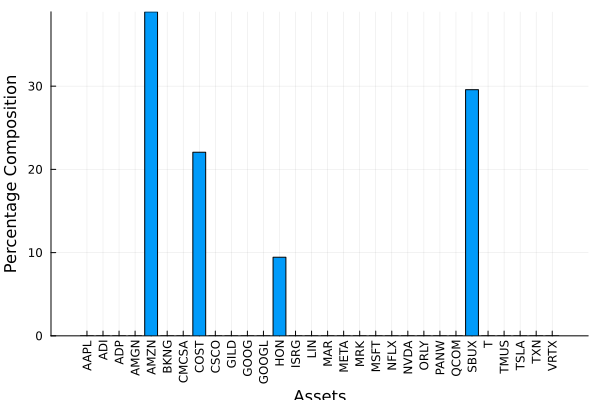

In [4]:
bl_type = BLType()
black_litterman_statistics!(port; P = P, Q = Q, w = w1.weights, mu_type = mu_type,
                            cov_type = cov_type)

# Creating the optimisation object.
rm = SD() # Risk measure.
obj = Sharpe() # Objective function. Can be `MinRisk()`, `Utility()`, `Sharpe()`, `MaxRet()`.
class = BL()
# `Trad` optimisation corresponds to the classic mean risk optimisation.
type = Trad(; rm = rm, obj = obj, class = class)

# Optimise Black Litterman portfolio.
w2 = optimise!(port, type)
pretty_table(w2; formatters = fmt2)
plot_bar(port)

## 3. Efficient Frontier

It's possible to compute the efficient frontier of the Black Litterman model. It will be different to the vanilla one because the expected returns and covariance matrix have been adjusted.

In [5]:
points = 50
frontier = efficient_frontier!(port, type; points = points)
pretty_table(frontier[:weights]; formatters = fmt2)

┌─────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬─────────┬──────────┬─────────┬──────────┐
│ tickers │        1 │        2 │        3 │        4 │        5 │        6 │        7 │        8 │        9 │       10 │       11 │       12 │       13 │       14 │       15 │       16 │       17 │       18 │       19 │       20 │       21 │       22 │       23 │       24 │       25 │       26 │       27 │       28 │       29 │       30 │       31 │       32 │       33 │       34 │       35 │       36 │       37 │       38 │

Plot frontier.

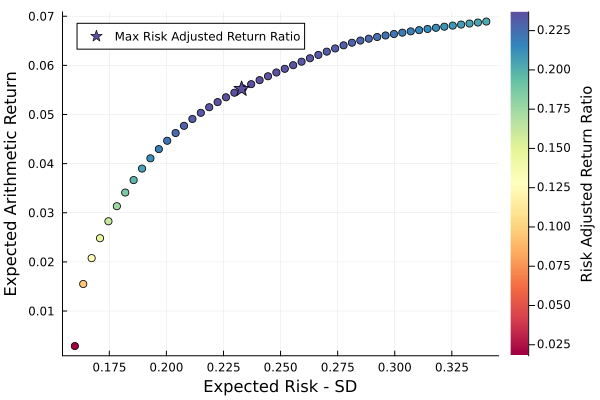

In [6]:
plot_frontier(port; rm = rm)

Plot frontier area.

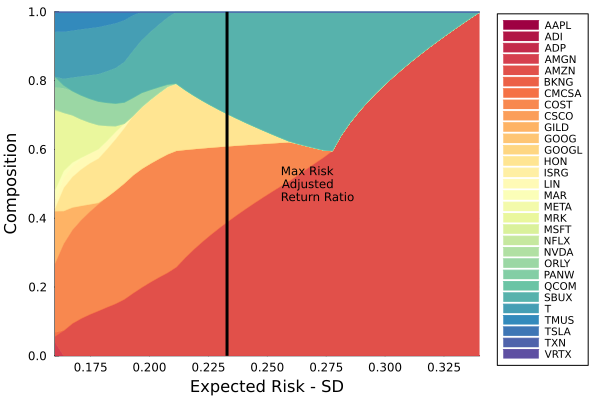

In [7]:
plot_frontier_area(port; rm = rm, kwargs_a = (; legendfontsize = 7))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*